In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

In [2]:
file = './TestData/tz_swahili.rttm'

In [3]:
# This is to make our lives easier later
ny_7759 = DfFromRttm(file)
ny_7759_bak = copy.deepcopy(ny_7759)

NameError: name 'DfFromRttm' is not defined

In [ ]:
# This is to make our lives easier later
ny_0287 = DfFromRttm(file)
ny_0287_bak = copy.deepcopy(ny_0287)

### RTTM to Dataframe

In [4]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Audiozation Data

In [5]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

In [7]:
RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
0,0.041,0.289,CHILD,1,0.289,1
1,11.148,1.549,CHILD,1,1.549,1
3,13.492,3.827,CHILD,1,3.827,1
5,20.183,0.132,CHILD,1,0.132,1
6,20.993,2.255,CHILD,1,2.255,1
...,...,...,...,...,...,...
369,1234.668,2.602,ADULT,-1,-2.602,1
370,1236.011,14.435,ADULT,-1,-14.435,1
371,1251.457,14.123,ADULT,-1,-14.123,1
372,1251.656,0.275,ADULT,-1,-0.275,1


## Time-Indexed Dataframe

In [8]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [10]:
## Create millisecond index.
def MakeMillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=4,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*1000),
                        stop  = int(round(start+duration, decimals)*1000),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [11]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [12]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                MakeMillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 4,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)
            
    return outer_df

In [14]:
tester = DfFromRttm(file)
labels = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH']
tester[['start', 'duration']].loc[2]

start       13.492
duration     1.075
Name: 2, dtype: float64

In [15]:
result = BuildOneHotEncodedDf(tester, label_list=labels, verbose=True)


        >> This DF has data that runs until 1266.388.
        >> That value was found at row 363 and is the sum of
           1192.84 and 73.548
        
max_seconds_needed is equal to 1266.388
 >>> From [0] for [1266.388] seconds until [1266.388] the col [base_col] will contain the value [nan]
                  base_col
millisecond_ints          
0                      NaN
1                      NaN
2                      NaN                   base_col
millisecond_ints          
1266385                NaN
1266386                NaN
1266387                NaN
The outer_df frame will contain 1266388 records.
>>> Processing label: MAL

The temp_df subset for label MAL contains 27 rows
      start  duration class
37   80.092     0.975   MAL
39  107.225     0.364   MAL
46  140.368     1.520   MAL
79  254.219     0.103   MAL
81  255.216     1.239   MAL         start  duration class
360  1136.754     0.599   MAL
362  1182.421     1.968   MAL
368  1232.493     0.498   MAL
369  1234.668     2


>>> Base DF size after 6 rounds: {len(label_base_df)}

>>> The head:
                  MAL
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  MAL
millisecond_ints     
436392            1.0
436393            1.0
436394            1.0
436395            1.0
436396            1.0
436397            1.0
436398            1.0
436399            1.0
436400            1.0
436401            1.0

>>> A few of its contents:
                  MAL
millisecond_ints     
80092             1.0
80093             1.0
80094             1.0
80095             1.0
80096             1.0
**********MAL: i = 7**********
 >>> From [442.139] for [0.447] seconds until [442.586] the col [MAL] will contain the value [1]
                  MAL
millisecond_ints     
442139              1
442140      


>>> A few of its contents:
                  MAL
millisecond_ints     
80092             1.0
80093             1.0
80094             1.0
80095             1.0
80096             1.0
**********MAL: i = 19**********
 >>> From [1063.348] for [0.14300000000000002] seconds until [1063.491] the col [MAL] will contain the value [1]
                  MAL
millisecond_ints     
1063348             1
1063349             1
1063350             1                   MAL
millisecond_ints     
1063488             1
1063489             1
1063490             1

>>> Base DF size after 19 rounds: {len(label_base_df)}

>>> The head:
                  MAL
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  MAL
millisecond_ints     
1063481           1.0
1063482           1.0
1063483         

                  base_col  MAL
millisecond_ints               
80092                  NaN  1.0
80093                  NaN  1.0
80094                  NaN  1.0
80095                  NaN  1.0
80096                  NaN  1.0
>>> Processing label: CHI

The temp_df subset for label CHI contains 98 rows
    start  duration class
0   0.041     0.289   CHI
1  11.148     1.549   CHI
3  13.492     3.827   CHI
5  20.183     0.132   CHI
6  20.993     2.255   CHI         start  duration class
347  1087.616     0.550   CHI
359  1134.182     0.275   CHI
361  1139.439     0.312   CHI
365  1197.558     0.582   CHI
373  1260.382     0.155   CHI
The temp_df frame is as follows:
       start  duration class
0      0.041     0.289   CHI
1     11.148     1.549   CHI
2     13.492     3.827   CHI
3     20.183     0.132   CHI
4     20.993     2.255   CHI
..       ...       ...   ...
93  1087.616     0.550   CHI
94  1134.182     0.275   CHI
95  1139.439     0.312   CHI
96  1197.558     0.582   CHI
97  1260.38

47364             1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 10**********
 >>> From [47.775] for [0.48100000000000004] seconds until [48.256] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
47775               1
47776               1
47777               1                   CHI
millisecond_ints     
48253               1
48254               1
48255               1

>>> Base DF size after 10 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
48246             1.0
48247             1.

198950              1                   CHI
millisecond_ints     
199539              1
199540              1
199541              1

>>> Base DF size after 22 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
199532            1.0
199533            1.0
199534            1.0
199535            1.0
199536            1.0
199537            1.0
199538            1.0
199539            1.0
199540            1.0
199541            1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 23**********
 >>> From [209.976] for [0.47600000000000


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 30**********
 >>> From [280.992] for [2.0] seconds until [282.992] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
280992              1
280993              1
280994              1                   CHI
millisecond_ints     
282989              1
282990              1
282991              1

>>> Base DF size after 30 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
282982            1.0
282983            1.0
282984            1.0
282985      


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 44**********
 >>> From [495.94599999999997] for [1.247] seconds until [497.193] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
495946              1
495947              1
495948              1                   CHI
millisecond_ints     
497190              1
497191              1
497192              1

>>> Base DF size after 44 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
497183            1.0
497184            1.0
497185            1.0


>>> Base DF size after 51 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
567979            1.0
567980            1.0
567981            1.0
567982            1.0
567983            1.0
567984            1.0
567985            1.0
567986            1.0
567987            1.0
567988            1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 52**********
 >>> From [570.512] for [0.9990000000000001] seconds until [571.511] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
570512             


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 66**********
 >>> From [933.512] for [0.9990000000000001] seconds until [934.511] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
933512              1
933513              1
933514              1                   CHI
millisecond_ints     
934508              1
934509              1
934510              1

>>> Base DF size after 66 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
934501            1.0
934502            1.0
934503            1


>>> Base DF size after 73 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
969440            1.0
969441            1.0
969442            1.0
969443            1.0
969444            1.0
969445            1.0
969446            1.0
969447            1.0
969448            1.0
969449            1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 74**********
 >>> From [970.7610000000001] for [1.318] seconds until [972.0790000000001] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
970761      


>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 88**********
 >>> From [1030.011] for [4.386] seconds until [1034.397] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
1030011             1
1030012             1
1030013             1                   CHI
millisecond_ints     
1034393             1
1034394             1
1034395             1

>>> Base DF size after 88 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
1034386           1.0
1034387           1.0
1034388           1.0
1034389 


>>> Base DF size after 95 rounds: {len(label_base_df)}

>>> The head:
                  CHI
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  CHI
millisecond_ints     
1139741           1.0
1139742           1.0
1139743           1.0
1139744           1.0
1139745           1.0
1139746           1.0
1139747           1.0
1139748           1.0
1139749           1.0
1139750           1.0

>>> A few of its contents:
                  CHI
millisecond_ints     
41                1.0
42                1.0
43                1.0
44                1.0
45                1.0
**********CHI: i = 96**********
 >>> From [1197.558] for [0.5820000000000001] seconds until [1198.14] the col [CHI] will contain the value [1]
                  CHI
millisecond_ints     
1197558           


>>> A few of its contents:
                  KCHI
millisecond_ints      
58011              1.0
58012              1.0
58013              1.0
58014              1.0
58015              1.0
**********KCHI: i = 6**********
 >>> From [138.255] for [1.067] seconds until [139.322] the col [KCHI] will contain the value [1]
                  KCHI
millisecond_ints      
138255               1
138256               1
138257               1                   KCHI
millisecond_ints      
139319               1
139320               1
139321               1

>>> Base DF size after 6 rounds: {len(label_base_df)}

>>> The head:
                  KCHI
millisecond_ints      
0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
>>> The tail:
                  KCHI
millisecond_ints      
139312             1.0
139313             1.0


>>> A few of its contents:
                  KCHI
millisecond_ints      
58011              1.0
58012              1.0
58013              1.0
58014              1.0
58015              1.0
**********KCHI: i = 14**********
 >>> From [426.782] for [1.32] seconds until [428.102] the col [KCHI] will contain the value [1]
                  KCHI
millisecond_ints      
426782               1
426783               1
426784               1                   KCHI
millisecond_ints      
428099               1
428100               1
428101               1

>>> Base DF size after 14 rounds: {len(label_base_df)}

>>> The head:
                  KCHI
millisecond_ints      
0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
>>> The tail:
                  KCHI
millisecond_ints      
428092             1.0
428093             1.

>>> Base DF size after 23 rounds: {len(label_base_df)}

>>> The head:
                  KCHI
millisecond_ints      
0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
>>> The tail:
                  KCHI
millisecond_ints      
801369             1.0
801370             1.0
801371             1.0
801372             1.0
801373             1.0
801374             1.0
801375             1.0
801376             1.0
801377             1.0
801378             1.0

>>> A few of its contents:
                  KCHI
millisecond_ints      
58011              1.0
58012              1.0
58013              1.0
58014              1.0
58015              1.0
**********KCHI: i = 24**********
 >>> From [811.799] for [0.6940000000000001] seconds until [812.4929999999999] the col [KCHI] will contain the value [1]
                  KCH

                  FEM
millisecond_ints     
122492              1
122493              1
122494              1                   FEM
millisecond_ints     
137963              1
137964              1
137965              1

>>> Base DF size after 6 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
137956            1.0
137957            1.0
137958            1.0
137959            1.0
137960            1.0
137961            1.0
137962            1.0
137963            1.0
137964            1.0
137965            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493   


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 21**********
 >>> From [262.882] for [17.629] seconds until [280.511] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
262882              1
262883              1
262884              1                   FEM
millisecond_ints     
280508              1
280509              1
280510              1

>>> Base DF size after 21 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
280501            1.0
280502            1.0
280503            1.0
280504   


>>> Base DF size after 29 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
313208            1.0
313209            1.0
313210            1.0
313211            1.0
313212            1.0
313213            1.0
313214            1.0
313215            1.0
313216            1.0
313217            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 30**********
 >>> From [313.764] for [10.284] seconds until [324.048] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
313764              1
313765   


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 37**********
 >>> From [387.496] for [2.7880000000000003] seconds until [390.284] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
387496              1
387497              1
387498              1                   FEM
millisecond_ints     
390281              1
390282              1
390283              1

>>> Base DF size after 37 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
390274            1.0
390275            1.0
390276            1


>>> Base DF size after 49 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
489209            1.0
489210            1.0
489211            1.0
489212            1.0
489213            1.0
489214            1.0
489215            1.0
489216            1.0
489217            1.0
489218            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 50**********
 >>> From [491.49300000000005] for [2.6460000000000004] seconds until [494.13900000000007] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints   


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 59**********
 >>> From [601.003] for [16.008] seconds until [617.0110000000001] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
601003              1
601004              1
601005              1                   FEM
millisecond_ints     
617008              1
617009              1
617010              1

>>> Base DF size after 59 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
617001            1.0
617002            1.0
617003            1.0


>>> Base DF size after 68 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
709113            1.0
709114            1.0
709115            1.0
709116            1.0
709117            1.0
709118            1.0
709119            1.0
709120            1.0
709121            1.0
709122            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 69**********
 >>> From [710.4069999999999] for [12.02] seconds until [722.4269999999999] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
710407      


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 77**********
 >>> From [815.01] for [16.980999999999998] seconds until [831.991] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
815010              1
815011              1
815012              1                   FEM
millisecond_ints     
831988              1
831989              1
831990              1

>>> Base DF size after 77 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
831981            1.0
831982            1.0
831983            1.


>>> Base DF size after 84 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
926988            1.0
926989            1.0
926990            1.0
926991            1.0
926992            1.0
926993            1.0
926994            1.0
926995            1.0
926996            1.0
926997            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 85**********
 >>> From [933.336] for [2.641] seconds until [935.977] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
933336              1
933337    


>>> Base DF size after 92 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
971002            1.0
971003            1.0
971004            1.0
971005            1.0
971006            1.0
971007            1.0
971008            1.0
971009            1.0
971010            1.0
971011            1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 93**********
 >>> From [977.063] for [1.195] seconds until [978.258] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
977063              1
977064    

43493             1.0
**********FEM: i = 100**********
 >>> From [1002.993] for [2.499] seconds until [1005.4920000000001] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
1002993             1
1002994             1
1002995             1                   FEM
millisecond_ints     
1005489             1
1005490             1
1005491             1

>>> Base DF size after 100 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
1005482           1.0
1005483           1.0
1005484           1.0
1005485           1.0
1005486           1.0
1005487           1.0
1005488           1.0
1005489           1.0
1005490           1.0
1005491           1.0

>


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 109**********
 >>> From [1083.896] for [9.946] seconds until [1093.8419999999999] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
1083896             1
1083897             1
1083898             1                   FEM
millisecond_ints     
1093839             1
1093840             1
1093841             1

>>> Base DF size after 109 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
1093832           1.0
1093833           1.0
1093834           


>>> A few of its contents:
                  FEM
millisecond_ints     
43489             1.0
43490             1.0
43491             1.0
43492             1.0
43493             1.0
**********FEM: i = 117**********
 >>> From [1236.011] for [14.435] seconds until [1250.446] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
1236011             1
1236012             1
1236013             1                   FEM
millisecond_ints     
1250443             1
1250444             1
1250445             1

>>> Base DF size after 117 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
1250436           1.0
1250437           1.0
1250438           1.0
12504

39991                1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 7**********
 >>> From [42.992] for [5.0] seconds until [47.992] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
42992                  1
42993                  1
42994                  1                   SPEECH
millisecond_ints        
47989                  1
47990                  1
47991                  1

>>> Base DF size after 7 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
        

148194               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 16**********
 >>> From [148.745] for [21.345] seconds until [170.09] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
148745                 1
148746                 1
148747                 1                   SPEECH
millisecond_ints        
170087                 1
170088                 1
170089                 1

>>> Base DF size after 16 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
  


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 23**********
 >>> From [291.754] for [3.051] seconds until [294.805] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
291754                 1
291755                 1
291756                 1                   SPEECH
millisecond_ints        
294802                 1
294803                 1
294804                 1

>>> Base DF size after 23 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
mi


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 30**********
 >>> From [357.49199999999996] for [15.52] seconds until [373.01199999999994] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
357492                 1
357493                 1
357494                 1                   SPEECH
millisecond_ints        
373009                 1
373010                 1
373011                 1

>>> Base DF size after 30 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
     


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 38**********
 >>> From [445.917] for [3.576] seconds until [449.493] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
445917                 1
445918                 1
445919                 1                   SPEECH
millisecond_ints        
449490                 1
449491                 1
449492                 1

>>> Base DF size after 38 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
mi


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 47**********
 >>> From [592.446] for [1.25] seconds until [593.696] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
592446                 1
592447                 1
592448                 1                   SPEECH
millisecond_ints        
593693                 1
593694                 1
593695                 1

>>> Base DF size after 47 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
mil

679231                 1                   SPEECH
millisecond_ints        
680007                 1
680008                 1
680009                 1

>>> Base DF size after 56 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
680000               1.0
680001               1.0
680002               1.0
680003               1.0
680004               1.0
680005               1.0
680006               1.0
680007               1.0
680008               1.0
680009               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495       


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 63**********
 >>> From [849.012] for [21.48] seconds until [870.492] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
849012                 1
849013                 1
849014                 1                   SPEECH
millisecond_ints        
870489                 1
870490                 1
870491                 1

>>> Base DF size after 63 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
mi


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 72**********
 >>> From [946.492] for [0.113] seconds until [946.605] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
946492                 1
946493                 1
946494                 1                   SPEECH
millisecond_ints        
946602                 1
946603                 1
946604                 1

>>> Base DF size after 72 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
mi


>>> Base DF size after 78 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
millisecond_ints        
972983               1.0
972984               1.0
972985               1.0
972986               1.0
972987               1.0
972988               1.0
972989               1.0
972990               1.0
972991               1.0
972992               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 79**********
 >>> From [977.01] for [1.46] seconds until [978.47] the col [SPEECH] will co


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 85**********
 >>> From [1027.266] for [0.15] seconds until [1027.4160000000002] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
1027266                1
1027267                1
1027268                1                   SPEECH
millisecond_ints        
1027412                1
1027413                1
1027414                1

>>> Base DF size after 85 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                


>>> A few of its contents:
                  SPEECH
millisecond_ints        
13492                1.0
13493                1.0
13494                1.0
13495                1.0
13496                1.0
**********SPEECH: i = 94**********
 >>> From [1083.9] for [10.004] seconds until [1093.904] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
1083900                1
1083901                1
1083902                1                   SPEECH
millisecond_ints        
1093901                1
1093902                1
1093903                1

>>> Base DF size after 94 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                  SPEECH
m

In [16]:
result.head(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
result.tail(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
1266368,NaN,NaN,NaN,NaN,NaN,1.0
1266369,NaN,NaN,NaN,NaN,NaN,1.0
1266370,NaN,NaN,NaN,NaN,NaN,1.0
1266371,NaN,NaN,NaN,NaN,NaN,1.0
1266372,NaN,NaN,NaN,NaN,NaN,1.0
1266373,NaN,NaN,NaN,NaN,NaN,1.0
1266374,NaN,NaN,NaN,NaN,NaN,1.0
1266375,NaN,NaN,NaN,NaN,NaN,1.0
1266376,NaN,NaN,NaN,NaN,NaN,1.0


In [19]:
result.loc[495000:495050]

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
495000,NaN,NaN,1.0,NaN,NaN,1.0
495001,NaN,NaN,1.0,NaN,NaN,1.0
495002,NaN,NaN,1.0,NaN,NaN,1.0
495003,NaN,NaN,1.0,NaN,NaN,1.0
495004,NaN,NaN,1.0,NaN,NaN,1.0
495005,NaN,NaN,1.0,NaN,NaN,1.0
495006,NaN,NaN,1.0,NaN,NaN,1.0
495007,NaN,NaN,1.0,NaN,NaN,1.0
495008,NaN,NaN,1.0,NaN,NaN,1.0


In [20]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,24879.0,119178.0,17134.0,930319.0,1106545.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [27]:
result.shape

(1266388, 3)

### Data Cleanup

In [22]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [23]:
# Combine MAL/FEM and KCHI/CHI
result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)

In [24]:
# Drop MAL/FEM and KCHI/CHI columns
result = result.drop(['MAL', 'CHI', 'KCHI', 'FEM'], axis=1)

In [28]:
# Combine ADULT and CHILD columns
result['SPEECH'] = result.apply(lambda x: 0 if (x['ADULT']==0 and x['CHILD']==0) else 1, axis=1)

In [29]:
# Smooth data by eliminating pauses less than back_window + forward_window 
# milliseconds between consecutive statements.

back_window = 500
forward_window = 500

adult_window_back = result['ADULT'].rolling(back_window).sum()
adult_window_for = result['ADULT'].iloc[::-1].rolling(forward_window).sum()

child_window_back = result['CHILD'].rolling(back_window).sum()
child_window_for = result['CHILD'].iloc[::-1].rolling(forward_window).sum()

result['SMOOTH_A'] = np.where((adult_window_back >= 1) & (adult_window_for >= 1), 1, 0)
result['SMOOTH_C'] = np.where((child_window_back >= 1) & (child_window_for >= 1), 1, 0)

In [30]:
# Combine SMOOTH_A and SMOOTH_C columns
result['SMOOTH_S'] = result.apply(lambda x: 0 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==0) else 1, axis=1)

In [31]:
result.loc[495000:495050,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S
millisecond_ints,,,,,,
495000,0,1,1,0,1,1
495001,0,1,1,0,1,1
495002,0,1,1,0,1,1
495003,0,1,1,0,1,1
495004,0,1,1,0,1,1
495005,0,1,1,0,1,1
495006,0,1,1,0,1,1
495007,0,1,1,0,1,1
495008,0,1,1,0,1,1


### Calculated Variables

In [32]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

In [33]:
# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [34]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['UTT_A'] = result.ADULT.diff()
result['UTT_C'] = result.CHILD.diff()
result['UTT_S'] = result.SPEECH.diff()

In [35]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['SMOOTH_UTT_A'] = result.SMOOTH_A.diff()
result['SMOOTH_UTT_C'] = result.SMOOTH_C.diff()
result['SMOOTH_UTT_S'] = result.SMOOTH_S.diff()

In [36]:
result.loc[300180:300200,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S,OVERLAP,PAUSE,SMOOTH_OVERLAP,SMOOTH_PAUSE,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
millisecond_ints,,,,,,,,,,,,,,,,
300180,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300181,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300182,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300183,1,0,1,1,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
300184,1,1,1,1,1,1,1,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0
300185,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
300186,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
300187,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
300188,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


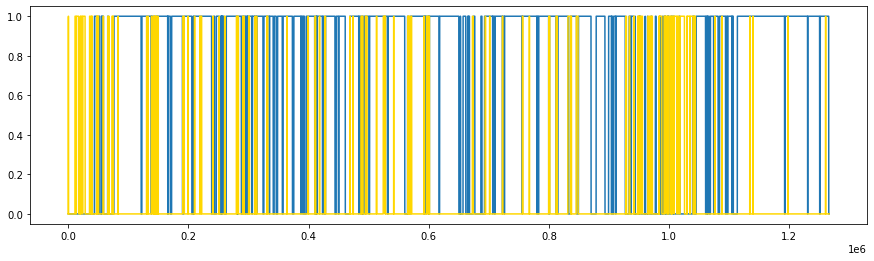

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(result.index, result['ADULT'])
plt.plot(result.index, result['CHILD'], color='gold')
plt.show()

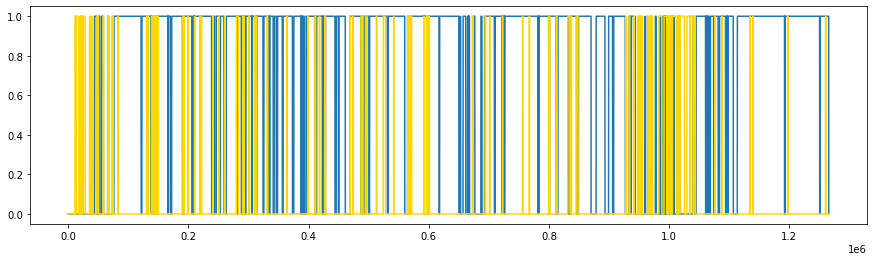

In [38]:
plt.figure(figsize=(15, 4))
plt.plot(result.index, result['SMOOTH_A'])
plt.plot(result.index, result['SMOOTH_C'], color='gold')
plt.show()

In [39]:
# Write output to CSV.
#result.to_csv('./TestData/eNY-0287.csv')

## TeacherPrint Data

In [40]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [41]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.001,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 21 min 06 sec


### Talk Time
#### Raw

In [42]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_att = round(result['ADULT'].sum()*.001, 1)
tp_att_pc = int(round((tp_att/tp_tt)*100, 0))
print(tp_att, tp_att_pc)

# Calculate student talktime (sec and %).
tp_ctt = round(result['CHILD'].sum()*.001, 1)
tp_ctt_pc = int(round((tp_ctt/tp_tt)*100, 0))
print(tp_ctt, tp_ctt_pc)

print('During your lesson you spoke ' 
      + str(tp_att_pc) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_att/tp_ctt, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 17 min 45 sec
937.2 88
128.1 12
During your lesson you spoke 88% of the time and the Students spoke 12% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [43]:
# Calculate total smoothed talktime (sec).
tp_tt_s = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt_s)) 

# Calculate teacher talktime (sec and %).
tp_att_s = round(result['SMOOTH_A'].sum()*.001, 1)
tp_att_pc_s = int(round((tp_att_s/tp_tt_s)*100, 0))
print(tp_att_s, tp_att_pc_s)

# Calculate student talktime (sec and %).
tp_ctt_s = round(result['SMOOTH_C'].sum()*.001, 1)
tp_ctt_pc_s = int(round((tp_ctt_s/tp_tt_s)*100, 0))
print(tp_ctt_s, tp_ctt_pc_s)

print('During your lesson you spoke ' 
      + str(tp_att_pc_s) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc_s) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric_s = int(round(tp_att_s/tp_ctt_s, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric_s) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 18 min 05 sec
948.8 87
137.0 13
During your lesson you spoke 87% of the time and the Students spoke 13% of the time.
For every second of Student talk time, there were about 7 seconds of Teacher talk time.


### Statements
#### Raw

In [44]:
#Calculate number of statements.
tp_utt_a = result['UTT_A'].value_counts()[1]
tp_utt_c = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_a + tp_utt_c
print("TOTAL STATEMENTS: " + str(tp_utt)) 
print(tp_utt_a, tp_utt_c)

# Calculate average statement length.
tp_uttlen_a = round((tp_att/tp_utt_a), 1)
tp_uttlen_c = round((tp_ctt/tp_utt_c), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c) + ' seconds long.')

# Calculate the Statement metric ("For every second...".
tp_utt_metric = int(round(tp_uttlen_a/tp_uttlen_c, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric) + ' seconds of Teacher statements.')

TOTAL STATEMENTS: 234
120 114
Your average statement was 7.8 seconds long, while the average Student statement was 1.1 seconds long.
For every second of Student statements, there were about 7 seconds of Teacher statements.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [37]:
#Calculate number of smoothed statements.
tp_utt_a_s = result['SMOOTH_UTT_A'].value_counts()[1]
tp_utt_c_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_utt_s = tp_utt_a_s + tp_utt_c_s
print("TOTAL STATEMENTS: " + str(tp_utt_s)) 
print(tp_utt_a_s, tp_utt_c_s)

# Calculate average smoothed statement length.
tp_uttlen_a_s = round((tp_att_s/tp_utt_a_s), 1)
tp_uttlen_c_s = round((tp_ctt_s/tp_utt_c_s), 1)

print('Your average statement was ' 
      + str(tp_uttlen_a_s) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c_s) + ' seconds long.')


# Calculate the Statement metric ("For every second...".
tp_utt_metric_s = int(round(tp_uttlen_a_s/tp_uttlen_c_s, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric_s) + ' seconds of Teacher statements.')

TOTAL STATMENTS: 227
117 110
Your average statement was 8.1 seconds long, while the average Student statement was 1.2 seconds long.
For every second of Student statements, there were about 7 seconds of Teacher statements.


### Pauses

#### Raw

In [38]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.001, 1)
tp_pt_avg = (round((tp_pt/tp_utt), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg)) 

#Calculate number of pauses.
tp_pause_a = result['UTT_A'].value_counts()[-1]
tp_pause_a_avg = (round((tp_pause_a/tp_utt_a), 1))
print(tp_pause_a, tp_pause_a_avg)

tp_pause_c = result['UTT_C'].value_counts()[-1]
tp_pause_c_avg = (round((tp_pause_c/tp_utt_c), 1))
print(tp_pause_c, tp_pause_c_avg)

tp_pause_c = result['UTT_S'].value_counts()[-1]
tp_pause_pc = int(round((tp_pause_c/tp_utt)*100, 0))
print(tp_pause_c, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 57 sec
AVERAGE PAUSE TIME: 00 min 01 sec
120 1.0
114 1.0
156 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 67% of Statements had pauses between them.


#### Smoothed

In [39]:
# Calculate pause time (sec).
tp_pt_s = round(result['SMOOTH_PAUSE'].sum()*.001, 1)
tp_pt_avg_s = (round((tp_pt_s/tp_utt_s), 1))
print("TOTAL PAUSE TIME: " + convert(tp_pt_s)) 
print("AVERAGE PAUSE TIME: " + convert(tp_pt_avg_s)) 

#Calculate number of pauses.
tp_pause_a_s = result['SMOOTH_UTT_A'].value_counts()[-1]
tp_pause_a_avg_s = (round((tp_pause_a_s/tp_utt_a_s), 1))
print(tp_pause_a_s, tp_pause_a_avg_s)

tp_pause_c_s = result['SMOOTH_UTT_C'].value_counts()[-1]
tp_pause_c_avg_s = (round((tp_pause_c_s/tp_utt_c_s), 1))
print(tp_pause_c_s, tp_pause_c_avg_s)

tp_pause_s = result['SMOOTH_UTT_S'].value_counts()[-1]
tp_pause_pc_s = int(round((tp_pause_s/tp_utt_s)*100, 0))
print(tp_pause_s, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg_s) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg_s) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc_s) 
      + '% of Statements had pauses between them.')

TOTAL PAUSE TIME: 03 min 42 sec
AVERAGE PAUSE TIME: 00 min 01 sec
117 1.0
110 1.0
144 67
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 63% of Statements had pauses between them.


### Overlaps
Still need to figure out directionality.

#### Raw

In [40]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot)) 

tp_overlap_pc = 100 - tp_pause_pc
tp_ot_avg = round(tp_ot/(tp_overlap_pc*tp_utt), 3)

print('The average overlap was about ' + str(tp_ot_avg) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 36 sec
The average overlap was about 0.005 seconds.
In this lesson 33% of Statements had overlaps between them.


#### Smoothed

In [41]:
# Calculate smoothed overlap time (sec).
tp_ot_s = round(result['SMOOTH_OVERLAP'].sum()*.001, 1)
print("TOTAL OVERLAP TIME: " + convert(tp_ot_s)) 

tp_overlap_pc_s = 100 - tp_pause_pc_s
tp_ot_avg_s = round(tp_ot_s/(tp_overlap_pc_s*tp_utt_s), 3)

print('The average overlap was about ' + str(tp_ot_avg_s) + ' seconds.')

print('In this lesson ' + str(tp_overlap_pc_s) 
      + '% of Statements had overlaps between them.')

TOTAL OVERLAP TIME: 00 min 41 sec
The average overlap was about 0.005 seconds.
In this lesson 37% of Statements had overlaps between them.


### Speaker Wheel
#### Raw

In [42]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_att-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_ctt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 71, 'OVERLAPS': 3, 'STUDENT': 7, 'PAUSES': 19}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [43]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
sw_adult_s = int(round((tp_att_s-tp_ot_s)/tp_time*100))
sw_overlap_s = int(round(tp_ot_s/tp_time*100))
sw_child_s = int(round((tp_ctt_s-tp_ot_s)/tp_time*100))
sw_pause_s = int(round(tp_pt_s/tp_time*100))
sw_df_s = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df_s

{'TEACHER': 71, 'OVERLAPS': 3, 'STUDENT': 7, 'PAUSES': 19}

## Troubleshooting statement counts

In [46]:
tshoot = RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

In [56]:
tshoot.head()

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
0,0.041,0.289,CHILD,1,0.289,1
1,11.148,1.549,CHILD,1,1.549,1
3,13.492,3.827,CHILD,1,3.827,1
5,20.183,0.132,CHILD,1,0.132,1
6,20.993,2.255,CHILD,1,2.255,1


In [70]:
tot_lab_ct = 0
for lab in tshoot['LABEL'].unique():
    lab_ct = abs(tshoot[tshoot["LABEL"]==lab].sum()["LABEL_NUM"])
    print(f'There were {lab_ct} {lab} statements in the RTTM')
    tot_lab_ct += lab_ct
print(f'Total labels: {tot_lab_ct}')

There were 128 CHILD statements in the RTTM
There were 146 ADULT statements in the RTTM
Total labels: 274


In [67]:
tshoot[tshoot["LABEL"]==lab].sum()

START                                                  92994.9
DUR                                                    955.199
LABEL        ADULTADULTADULTADULTADULTADULTADULTADULTADULTA...
LABEL_NUM                                                 -146
DUR_TRANS                                             -955.199
COUNT                                                      146
dtype: object

In [64]:
tshoot.where(tshoot["LABEL"]==lab).sum()["LABEL_NUM"]

-146.0

In [74]:
tshoot['START_ROUNDED'] = round(tshoot['START'], 4)

In [94]:
len(tshoot['START'].unique()), len(tshoot['START_ROUNDED'].unique())
# tshoot[['START', 'START_ROUNDED']].head()

(274, 274)

In [143]:
chiStartsRttm = tshoot[tshoot['LABEL']=='CHILD']['START_ROUNDED'] \
    .reset_index() \
    .rename(columns = {'START_ROUNDED': 'time_Rttm',
                      })
print(f'Rows: {len(chiStartsRttm)}')
chiStartsRttm.head(5)

Rows: 128


,index,time_Rttm
0,0,0.041
1,1,11.148
2,3,13.492
3,5,20.183
4,6,20.993


In [144]:
chiStartsMSIndex = result[result['UTT_C']==1.0] \
    .reset_index()['millisecond_ints'] \
    .reset_index() \
    .rename(columns = {'millisecond_ints':'time_Results',
#                        'index': 'pos_Results'
                      })
print(f'Rows: {len(chiStartsMSIndex)}')
chiStartsMSIndex.head(5)

Rows: 114


,index,time_Results
0,0,41
1,1,11148
2,2,13492
3,3,20183
4,4,20993


In [149]:
joined = pd.merge(left  = chiStartsRttm,
                  right = chiStartsMSIndex,
                  how   = 'outer')

In [147]:
len(joined)

193

In [150]:
joined.head(40)

,index,time_Rttm,time_Results
0,0,0.041,41.0
1,1,11.148,11148.0
2,3,13.492,20183.0
3,5,20.183,24221.0
4,6,20.993,35333.0
5,9,24.221,47191.0
6,12,35.333,58011.0
7,14,37.992,67753.0
8,15,39.413,72620.0
9,18,47.191,130354.0
